In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense,Flatten,Activation, RepeatVector, Permute, Lambda, multiply
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import backend as K
from textblob import TextBlob

In [2]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
LSTM_UNITS = 128
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

In [3]:
df = pd.read_csv('IMDBe2.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [4]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

In [5]:
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the dataset into training and testing sets
y = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
def get_emotion(text):
    blob = TextBlob(text)
    return np.array([blob.sentiment.polarity, blob.sentiment.subjectivity])

emotional_features = np.zeros((len(x), 2))
for i, text in enumerate(df["review"]):
    emotional_features[i] = get_emotion(text)

print(emotional_features)

[[ 0.02343318  0.49036866]
 [ 0.10972222  0.55934343]
 [ 0.35400794  0.65873016]
 ...
 [ 0.05238321  0.49220328]
 [-0.44285714  0.57142857]
 [ 0.09243197  0.52615646]]


In [7]:
len(emotional_features)

2000

In [12]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
lstm_output = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)
lstm_output = Dropout(0.5)(lstm_output)
attention = Dense(1, activation='tanh')(lstm_output)  #it is a fully coonected layer with activation function tanh
attention = Flatten()(attention)  #the out of lstm network is fed into the Attention layer
attention = Activation('softmax')(attention)
attention = RepeatVector(LSTM_UNITS*2)(attention) #this layer makes sure that the assigned weights are of same length
attention = Permute([2, 1])(attention)
sent_representation = multiply([lstm_output, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(LSTM_UNITS*2,))(sent_representation)
outputs = Dense(1, activation="sigmoid")(sent_representation)
model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(loss="binary_crossentropay", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     2000000     ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 256)    234496      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 dropout_1 (Dropout)            (None, 100, 256)     0           ['bidirectional_1[0][0]']    

In [15]:
history = model.fit([x_train,emotional_features], y_train, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/10
10/10 [==============================] - 17s 1s/step - loss: 0.6928 - accuracy: 0.5070 - val_loss: 0.6914 - val_accuracy: 0.5031
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 0.6724 - accuracy: 0.6961 - val_loss: 0.6172 - val_accuracy: 0.7188
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.4282 - accuracy: 0.8250 - val_loss: 0.5553 - val_accuracy: 0.7125
Epoch 4/10
10/10 [==============================] - 8s 801ms/step - loss: 0.2028 - accuracy: 0.9438 - val_loss: 0.6851 - val_accuracy: 0.7375
Epoch 5/10
10/10 [==============================] - 9s 948ms/step - loss: 0.0771 - accuracy: 0.9742 - val_loss: 0.7132 - val_accuracy: 0.7250
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.0351 - accuracy: 0.9922 - val_loss: 0.9772 - val_accuracy: 0.7500
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.9126 - val_accuracy: 0.7469
Epoch 8/10
10/10

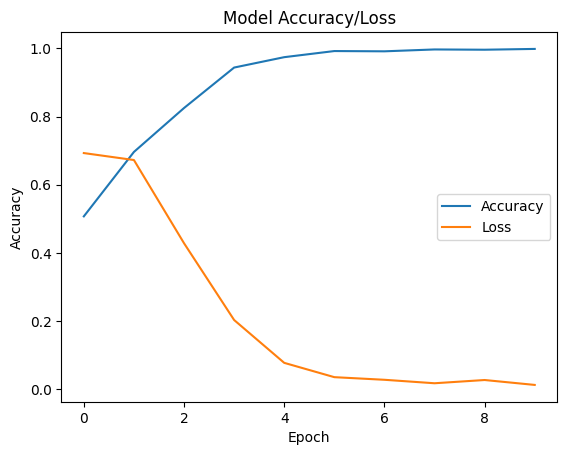

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'], loc = 'center right')
plt.show()

In [18]:
validation_size = 75
batch_size = 32
x_validate = x_test[-validation_size:]
y_validate = y_test[-validation_size:]
x_test = x_test[:-validation_size]
y_test = y_test[:-validation_size]
score,acc = model.evaluate(x_test, y_test, verbose = 1, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

11/11 [==============================] - 1s 90ms/step - loss: 1.4254 - accuracy: 0.6954
Score: 1.43
Validation Accuracy: 0.70


In [2]:
import scipy.stats as stats
import numpy as np

AECLSTM_acc = [0.9984,0.9898,0.9961,0.9969,0.9914]

mean_acc = np.mean(AECLSTM_acc)
std_error = stats.sem(AECLSTM_acc)

print('Mean accuracy: {:.4f} +/- {:.4f}'.format(mean_acc,std_error))

Mean accuracy: 0.9945 +/- 0.0017
